In [1]:
#pip install PySPG

In [2]:
# following tutorial at
# https://gsas-ii.readthedocs.io/en/latest/GSASIIscriptable.html#peak-fitting

In [3]:
import os,sys
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import csv
sys.path.insert(0,'/Users/dtn1/gsas2full/GSASII/') # needed to "find" GSAS-II modules
import GSASIIscriptable as G2sc

GSAS-II binary directory: C:\Users\dtn1\gsas2full\GSASII\bindist
6 values read from config file C:\Users\dtn1\gsas2full\GSASII\config.py


In [4]:
ScriptDirectory=os.getcwd()
GitLabDirectory=os.path.dirname(os.getcwd())
ExampleDataDirectory=os.path.join(GitLabDirectory,"ExampleData")
SaveDataDirectory=os.path.join(GitLabDirectory,"SaveData")

In [9]:
GitLabDirectory

'C:\\Users\\dtn1\\Documents\\AusteniteCalc\\austenitecalculator'

In [10]:

datadir = os.path.expanduser(ExampleDataDirectory)
SaveDir= os.path.expanduser(SaveDataDirectory)
DataPathWrap = lambda fil: os.path.join(datadir,fil)
SaveWrap = lambda fil: os.path.join(SaveDir,fil)
gpx = G2sc.G2Project(newgpx=SaveWrap('pkfit.gpx'))
hist = gpx.add_powder_histogram(DataPathWrap('Gonio_BB-HD-Cu_Gallipix3d[30-120]_New_Control_proper power.xrdml'),
                                DataPathWrap('TestCalibration.instprm'), # need to get a 
                                fmthint='Panalytical xrdml (xml)', databank=1, instbank=1)

C:\Users\dtn1\Documents\AusteniteCalc\austenitecalculator\ExampleData\Gonio_BB-HD-Cu_Gallipix3d[30-120]_New_Control_proper power.xrdml block # 1 read by Reader Panalytical xrdml (xml)
Instrument parameters read: C:\Users\dtn1\Documents\AusteniteCalc\austenitecalculator\ExampleData\TestCalibration.instprm (G2 fmt) bank 1


In [14]:
#hist.data['data'][0]['hId']
#hist.data
#hist['data']['hId'].data

TypeError: list indices must be integers or slices, not str

In [24]:
#len(hist.data['data']) # 3 objects

#hist.data['data'][0] # dict: with some kind of meta-info?
#hist.data['data'][1] # np.array: see below
#hist.data['data'][2] # string: file name

[array([ 30.01432394,  30.04297182,  30.0716197 , ..., 119.8827235 ,
        119.91137138, 119.94001926]),
 array([3252., 3228., 3176., ..., 2154., 2119., 2189.]),
 array([0.0003075 , 0.00030979, 0.00031486, ..., 0.00046425, 0.00047192,
        0.00045683]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.])]

# From: https://gsas-ii.readthedocs.io/en/latest/GSASIIobj.html?highlight=Powder%20Diffraction%20Tree#powder-diffraction-tree-items
    
    Data 		

(list) The data consist of a list of 6 np.arrays containing in order:

    the x-postions (two-theta in degrees),
    the intensity values (Yobs),
    the weights for each Yobs value
    the computed intensity values (Ycalc)
    the background values
    Yobs-Ycalc


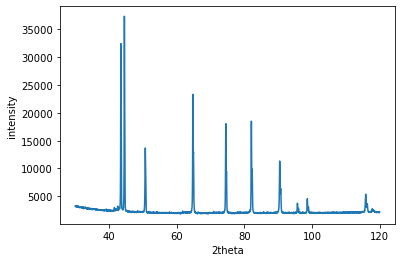

In [26]:
plt.plot(hist.data['data'][1][0], hist.data['data'][1][1])
plt.xlabel("2theta")
plt.ylabel("intensity")
plt.show()


In [ ]:
### Have not edited below this for austenite calculator

In [ ]:
dlist=[2.0923, 2.0923-0.05, 2.0923+0.05]
TOFlist=[]
for i in dlist:
    print(TOF_calc(i,16324.50,6.86,0.00))
    TOFlist.append(TOF_calc(i,16324.50,6.86,0.00))

In [ ]:


plt.xlim(TOFlist[1],TOFlist[2])
plt.plot(hist.data['data'][1][0], hist.data['data'][1][1])
plt.show()

In [ ]:
def OutputData(hist, append, Tick, LowLimit, HighLimit):
    # plot fit and difference
    plt.figure(figsize=[10,8])
    plt.scatter(hist.data['data'][1][0], hist.data['data'][1][1],color='k',label='Data')
    plt.plot(hist.data['data'][1][0], hist.data['data'][1][3],color='b',label='Computed Intensity')
    plt.plot(hist.data['data'][1][0], hist.data['data'][1][5],'-o',color='g',label='Difference')
    # vertical line for place of intial guess
    plt.vlines(Tick,0,plt.gca().get_ylim()[0]*0.5)
    # horizontal line to benchmark difference plot
    plt.hlines(0,plt.gca().get_xlim()[0],plt.gca().get_xlim()[1],'0.7')
    plt.xlim(LowLimit, HighLimit)
    plt.legend()
    # option to view on screen
    #plt.show()
    # option to save the plot
    plt.savefig("GSASPeakFit-"+append+".png", dpi=300)

    keys = hist.Peaks['sigDict'].keys()
    #print(keys)
    with open("GSASPeakFit-"+append+".csv",'a') as fd:
        wr=csv.writer(fd)
        dwr=csv.DictWriter(fd, keys)

        wr.writerow(['# TOF position (pos)', 'Area (int)','Alpha (alp)','Beta (bet)','Sigma (sig)','Gamma (gam)'])
        wr.writerow(['# Peak Parameter List'])
        wr.writerow(['# Peak Parameter Flags'])
        wr.writerow(hist.Peaks['peaks'][0][0::2])
        wr.writerow(hist.Peaks['peaks'][0][1::2])
        wr.writerow(["########################"])
        wr.writerow(['# Background Values'])
        wr.writerow(hist['Background'][0][3:])
        wr.writerow(["########################"])
        wr.writerow(['# SigDict Keys'])
        wr.writerow(['# SigDict Values'])
        dwr.writeheader()
        dwr.writerows([hist.Peaks['sigDict']])
        wr.writerow(["########################"])
        wr.writerow(['# Covariance Matrix'])
        wr.writerows(np.array(hist['Peak Fit Result'][1]))
        wr.writerow(["########################"])        
        wr.writerow(['# Correlation Matrix'])
        wr.writerows(np.corrcoef(hist['Peak Fit Result'][1]))
        wr.writerow(["########################"])        
        wr.writerow(['# Reduced ChiSq (GOF)'])
        wr.writerow([hist.data['Peak Fit Rvals']['GOF']])
        wr.writerow(["########################"])   
        wr.writerow(['# Dspacing (1 term) -/+ (3 terms)'])
        try:
            d=Dspace_calc(hist.Peaks['peaks'][0][0],16324.50,6.86,0.00)
            d_minus=Dspace_calc(hist.Peaks['peaks'][0][0]-hist.Peaks['sigDict']['pos0'],16324.50,6.86,0.00)
            d_plus=Dspace_calc(hist.Peaks['peaks'][0][0]+hist.Peaks['sigDict']['pos0'],16324.50,6.86,0.00)
            wr.writerow([d,d_minus,d_plus])
            wr.writerow([d,d-d_minus,d_plus-d])
        except:
            wr.writerow([Dspace_calc(hist.Peaks['peaks'][0][0],16324.50,6.86,0.00)])             
    fd.close()

In [ ]:
for i in range(len(hist.Peaks['peaks'])):
    print(i)

In [ ]:
hist['Background'][0][3:]

In [ ]:
hist.Peaks['peaks'][0][0::2]

In [ ]:
hist.Peaks['sigDict']

In [ ]:
#OutputData(hist, "", TOFlist[0],TOFlist[1],TOFlist[2])
# Doesn't work well prior to fitting

# Sequence 1, following Rawplot method

In [ ]:
# Define peaks to fit
#Limit is between the 422 and 333 peaks

hist.set_refinements({'Limits': [TOFlist[1],TOFlist[2]],  
      'Background': {"no. coeffs": 2,'type': 'chebyschev-1', 'refine': True}
                     })
# TOF data isn't listed right now.
peak1 = hist.add_peak(1, dspace=2.0923)




In [ ]:
# Following Rawplot method (seq1)

#area alone doesn't work well, since there is no positions
hist.set_peakFlags(area=True)
hist.refine_peaks()
OutputData(hist, "Seq1-Step1-Area",TOFlist[0],TOFlist[1],TOFlist[2])

#
hist.set_peakFlags(area=0,pos=True)
hist.refine_peaks()
OutputData(hist, "Seq1-Step2-Pos",TOFlist[0],TOFlist[1],TOFlist[2])

hist.set_peakFlags(area=True,pos=True)
hist.refine_peaks()
OutputData(hist, "Seq1-Step3-Pos-Area",TOFlist[0],TOFlist[1],TOFlist[2])

#These don't change sigma and gamma, but they do change alpha and beta...

hist.set_peakFlags(area=True, pos=0, sig=True)
hist.refine_peaks()
OutputData(hist, "Seq1-Step4-Area-Sig",TOFlist[0],TOFlist[1],TOFlist[2])

#hist.set_peakFlags(area=True, pos=True, gam=True)
#hist.refine_peaks()

hist.set_peakFlags(area=0, pos=0, sig=0, gam=True)
hist.refine_peaks()
OutputData(hist, "Seq1-Step5-Gam",TOFlist[0],TOFlist[1],TOFlist[2])

hist.set_peakFlags(area=True, pos=True, sig=True, gam=0)
hist.refine_peaks()
OutputData(hist, "Seq1-Step6-Area-Pos-Sig",TOFlist[0],TOFlist[1],TOFlist[2])



# hist.set_peakFlags(area=True, pos=True,alp=True,bet=True, sig=True, gam=True)
# hist.refine_peaks()
# OutputData(hist, "Seq-Area-Pos-Sig-Gam-Alp-Bet",TOFlist[0],TOFlist[1],TOFlist[2])


# Sequence 2 (Single background; alpha and beta refined, not gamma)

In [ ]:
# Define peaks to fit
#Limit is between the 422 and 333 peaks

hist.set_refinements({'Limits': [TOFlist[1],TOFlist[2]],  
      'Background': {"no. coeffs": 1,'type': 'chebyschev-1', 'refine': True}
                     })
# TOF data isn't listed right now.
peak1 = hist.add_peak(1, dspace=2.0923)




In [ ]:
# Following Rawplot method (seq2)

#area alone doesn't work well, since there is no positions
hist.set_peakFlags(area=True)
hist.refine_peaks()
OutputData(hist, "Seq2-Step1-Area",TOFlist[0],TOFlist[1],TOFlist[2])

#
hist.set_peakFlags(area=0,pos=True)
hist.refine_peaks()
OutputData(hist, "Seq2-Step2-Pos",TOFlist[0],TOFlist[1],TOFlist[2])

hist.set_peakFlags(area=True,pos=True)
hist.refine_peaks()
OutputData(hist, "Seq2-Step3-Pos-Area",TOFlist[0],TOFlist[1],TOFlist[2])

#These don't change sigma and gamma, but they do change alpha and beta...

hist.set_peakFlags(area=True, pos=0, sig=True)
hist.refine_peaks()
OutputData(hist, "Seq2-Step4-Area-Sig",TOFlist[0],TOFlist[1],TOFlist[2])

#hist.set_peakFlags(area=True, pos=True, gam=True)
#hist.refine_peaks()

hist.set_peakFlags(area=0, pos=0, sig=0, alp=True)
hist.refine_peaks()
OutputData(hist, "Seq2-Step5-Alp",TOFlist[0],TOFlist[1],TOFlist[2])

hist.set_peakFlags(alp=0, bet=True)
hist.refine_peaks()
OutputData(hist, "Seq2-Step6-Bet",TOFlist[0],TOFlist[1],TOFlist[2])

hist.set_peakFlags(area=True, pos=True, sig=True, bet=0)
hist.refine_peaks()
OutputData(hist, "Seq2-Step7-Area-Pos-Sig",TOFlist[0],TOFlist[1],TOFlist[2])



# hist.set_peakFlags(area=True, pos=True,alp=True,bet=True, sig=True, gam=True)
# hist.refine_peaks()
# OutputData(hist, "Seq-Area-Pos-Sig-Gam-Alp-Bet",TOFlist[0],TOFlist[1],TOFlist[2])


In [ ]:
gpx.get_Covariance(['0:0:Back;0','0:0:Back;1','0:0:pos0','0:0:int0','sig0'])

In [ ]:
hist.keys()

In [ ]:
hist['Background']

In [ ]:
hist['Peak Fit Result'][1]

In [ ]:
np.corrcoef(hist['Peak Fit Result'][1])

# Nothing run below this

In [ ]:
hist.Peaks['sigDict']

In [ ]:
hist.data

In [ ]:
if 'C' in hist.data['Instrument Parameters'][0]['Type'][0]:
    print("hi")
else:
    print("low")

In [ ]:
hist.data['Peak Fit Rvals']['GOF']

In [ ]:
hist.set_peakFlags(area=True, pos=True, sig=True)
hist.refine_peaks()
hist.set_peakFlags(area=True, pos=True, gam=True)
hist.refine_peaks()
hist.set_peakFlags(area=True, pos=True, sig=True, gam=True)
hist.refine_peaks()

In [ ]:
print('peak positions: ',[i[0] for i in hist.PeakList])
for i in range(len(hist.Peaks['peaks'])):
    print('peak',i,'pos=',hist.Peaks['peaks'][i][0],'sig=',hist.Peaks['sigDict']['pos'+str(i)])


In [ ]:
hist.Peaks['sigDict']

In [ ]:
# fit peaks
plt.plot(hist.data['data'][1][0], hist.data['data'][1][3],label='Computed Intensity')
plt.xlim(11752.,40000.)
plt.show()

In [ ]:
# fit difference
plt.figure(figsize=[10,8])
plt.plot(hist.data['data'][1][0], hist.data['data'][1][1],color='k',label='Data')
plt.plot(hist.data['data'][1][0], hist.data['data'][1][3],color='b',label='Computed Intensity')
plt.plot(hist.data['data'][1][0], hist.data['data'][1][5],color='g',label='Difference')
plt.xlim(11752.,40000.)
plt.legend()
plt.show()

In [ ]:
for i in range(len(hist.Peaks['peaks'])):
    print('peak',i)
    print('TOF pos=',hist.Peaks['peaks'][i][0],'sig=',hist.Peaks['sigDict']['pos'+str(i)])
    print('Dspace pos=', Dspace_calc(hist.Peaks['peaks'][i][0],16324.50,6.86,0.00),
          'sig (pos)=',Dspace_calc(hist.Peaks['peaks'][i][0]+hist.Peaks['sigDict']['pos'+str(i)],16324.50,6.86,0.00)-
          Dspace_calc(hist.Peaks['peaks'][i][0],16324.50,6.86,0.00),
          'sig (neg)=',Dspace_calc(hist.Peaks['peaks'][i][0],16324.50,6.86,0.00)-
          Dspace_calc(hist.Peaks['peaks'][i][0]-hist.Peaks['sigDict']['pos'+str(i)],16324.50,6.86,0.00))
    
    

In [ ]:
print(hist.Peaks)

## From GSASIIscriptable.py, lines 4007

        :returns: dict with two elements where item
          'peaks' is a list of peaks where each element is 
          [pos,pos-ref,area,area-ref,sig,sig-ref,gam,gam-ref], 
          where the -ref items are refinement flags and item
          'sigDict' is a dict with possible items 'Back;#', 
          'pos#', 'int#', 'sig#', 'gam#'
          
Fitting output lists:pos       esd       int       esd      alp     esd     bet     esd      sig       esd       gam       esd      bins

The fitting output values correspond to the column values

In [ ]:
#print(hist.Peaks)
HistDF=pd.DataFrame(hist.Peaks['peaks'], columns=['pos','pos-ref','area','area-ref','alph',
                                                  'alph-ref','bet','bet-ref','Sig','Sig-ref',
                                                  'Gam','gam-ref'])
print(HistDF)

In [ ]:
print(hist.Peaks['sigDict'])

In [ ]:
SigDF=pd.DataFrame(hist.Peaks['sigDict'])#, columns=['pos','pos-ref','area','area-ref','alph',
                                            #      'alph-ref','bet','bet-ref','Sig','Sig-ref',
                                            #      'Gam','gam-ref'])
print(SigDF)

In [ ]:
DataList=[]
for i in range(len(hist.Peaks['peaks'])):
    #print('peak',i)
    #print('TOF pos=',hist.Peaks['peaks'][i][0],'sig=',hist.Peaks['sigDict']['pos'+str(i)])
    DataList.append([i,hist.Peaks['peaks'][i][0],hist.Peaks['sigDict']['pos'+str(i)]])
#print(DataList)
ListDF=pd.DataFrame(DataList, columns=['Peak index','TOF Pos','TOF esd'])

#ListDF['Dspace Pos']=Dspace_calc(ListDF['TOF Pos'],16324.50,6.86,0.00)
ListDF['Dspace Pos']=ListDF.apply(lambda x: Dspace_calc(x['TOF Pos'],16324.50,6.86,0.00), axis=1)
ListDF['Dspace esd']=ListDF.apply(lambda x: Dspace_calc(x['TOF Pos']+x['TOF esd'],16324.50,6.86,0.00) - 
                                      Dspace_calc(x['TOF Pos'],16324.50,6.86,0.00), axis=1)
print(ListDF)
ListDF.to_csv('GSASPeakFit.csv')

In [ ]:
##  See further down on sequential refinements
# Sequential Refinement

# gpx.set_Controls('cycles',10)